<a href="https://colab.research.google.com/github/gwittich/Heart-Patient-Prognosis/blob/main/04_Heart_Patient__ModelTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Heart Patient Prognosis**

Data Scientist:   __Gail Wittich__<br>
Email:      gwittich@optusnet.com.au <br>
Website:    www.linkedin.com/in/gail-wittich <br>
Copyright:  Copyright 2020, Gail Wittich <br>

### **Install Packages**

In [1]:
!pip install Boruta

     |████████████████████████████████| 61kB 4.1MB/s 


### **Load Packages**

In [2]:
from boruta import BorutaPy                            # for feature selection
from google.colab import drive, files                  # for accessing files
import matplotlib.pyplot as plt                        # for data visualisation
import matplotlib.image as pltimg                      # for decsion tree
import numpy as np                                     # for numeric computations
import pickle                                          # for file reading and saving
import pandas as pd                                    # for data analysis
import pydotplus                                       # for decsion tree
import seaborn as sns                                  # for data visualisation
from sklearn.ensemble import RandomForestClassifier    # Random Forest Classifier model
from sklearn.linear_model import LogisticRegression    # Logistic regression model
from sklearn.model_selection import train_test_split, GridSearchCV    # to split the dataset into train and test, hyperparameter tuning
from sklearn.metrics import accuracy_score, f1_score   # for model evaluation
from sklearn.metrics import confusion_matrix, mean_squared_error        # for decsion tree
from sklearn.metrics import classification_report      # for LinearSVC
from sklearn import preprocessing                      # for data preprocessing
from sklearn import tree                               # for decsion tree
from sklearn.preprocessing import LabelEncoder         # for converting categorical to numerical data
from sklearn.svm import LinearSVC                      # for LinearSVC
from sklearn.tree import DecisionTreeClassifier        # for decsion tree

import warnings                                        # to ignore warnings
warnings.filterwarnings('ignore')

### **Define Classes**

In [3]:
class ModelContainer:
    
    def __init__(self, models=[]):       # default_num_iters=10, verbose_lvl=0):
        # initializes model list, dicts and variables
        self.models = []
        self.model_scores = []
        self.best_model = None
        self.predictions = None
        self.feature = None
        self.model_names = []
                 
    def add_model_detail(self, model, score):
        self.models.append(model)
        self.model_scores.append(score)
        model_name = container.extract_name(model)
        self.model_names.append(model_name)

    def select_best_model(self):
        # select model with lowest test_score
        best = self.model_scores[0]
        best_model = self.models[0]
        index = 0
        for i in range (len(self.models)):
            if self.model_scores[i] > best:
                best = self.model_scores[i]
                best_model = self.models[i]
                index += 1
        return best_model, best, index

    def get_important_features(self):     
        # Feature Correlation to Target
        cor = train_df.corr()
        # Show Correlation Heat Map
        print('Feature Importance using Correlation:\n')
        fig = plt.figure(figsize=(24, 20))
        colormap = sns.diverging_palette(500, 500, as_cmap = True)
        sns.heatmap(cor,
                    cmap = 'Blues',
                    square = True,
                    annot = True)
        plt.xticks(rotation = 45, ha = 'right')
        plt.show()
        print('\n')        
        col = cor.columns
        cor = abs(cor.Survived_1_year * 100) # make all importances positive(abs)
        print('\n')

        # Create lists of features with importances > 0.7  
        cor_col = []
        cor_col_imp = []
        for i, j in zip(col, cor):
            if(j >= 0.7):
                cor_col.append(i)
                cor_col_imp.append(j)

        # Bar Plot of feature importances
        fig = plt.figure(figsize = (24, 20))
        plt.bar(cor_col, cor_col_imp)
        plt.title("Feature Importance of most important Features", fontsize = 30)
        plt.xlabel('Feature')
        plt.ylabel('Importance')
        plt.xticks(rotation = 45, ha = 'right')
        plt.show()
        return cor_col

    def best_model_fit(self, features, targets):
        #fits best model
        self.best_model.fit(features, targets)
         
    def best_model_predict(self, features):
        # scores features using best model
        self.feature = features
        self.predictions = self.best_model.predict(features)

    def extract_name(self, model):
        # Extract name of model from saved model data
        s = str(model)
        model_name = s.split(sep='(')[0]
        print("Model Details for:   " + model_name)
        return model_name
        
    def save_results(self):
        print(best_model)
        with open('/content/drive/My Drive/Heart_Patient/Data/Best_Model.pkl', 'wb') as temp:
            pickle.dump(best_model, temp)
        return (self)

    def print_summary(self):
        # prints summary of models, best model, and feature importance
        print('\nModel Summaries\n')
        print("MODEL NAME\t\t\tMODEL ACCURACY")
        for model, score in zip(self.models, self.model_scores):
            s = str(model)
            print('\n', s.split(sep='(')[0], '\t\t', score)
        self.select_best_model()           
#        print("__"*50, '\nBest Model: ', self.best_model)


In [4]:
# Defining Class' Object instance
container = ModelContainer()

### **Load Data**

In [5]:
# mount the google drive
drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
# Unpickle Training data
train_df = pd.read_pickle('/content/drive/My Drive/Heart_Patient/Data/train_data_4_model.pkl')

# Unpickle Blind Testing data
test_df = pd.read_pickle('/content/drive/My Drive/Heart_Patient/Data/new_test_data_4_model.pkl')

In [7]:
train_df.head()

,ID_Patient_Care_Situation,Diagnosed_Condition,Patient_ID,Patient_Age,Patient_Body_Mass_Index,A,B,C,D,E,F,Z,Number_of_prev_cond,No_Drugs,DX1,DX2,DX3,DX4,DX5,DX6,Patient_Smoker_NO,Patient_Smoker_UNKNOWN,Patient_Smoker_YES,Patient_Rural_Urban_RURAL,Patient_Rural_Urban_URBAN,Survived_1_year
0,16201,47,8433,60,21.655523,1,0,0,0,1,0,0,2,0,0,1,0,0,0,0,1,0,0,0,1,1
1,9421,3,2972,2,28.852743,1,0,1,0,1,0,0,3,0,0,0,0,0,0,1,1,0,0,1,0,0
2,16205,7,8608,20,26.179725,1,0,0,0,1,0,0,2,0,0,0,0,0,0,1,1,0,0,1,0,1
3,5582,31,10074,8,22.638945,1,0,0,0,1,0,0,2,0,0,0,0,0,0,1,1,0,0,1,0,0
4,20880,43,7462,53,21.326131,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1


In [8]:
test_df.head()

,ID_Patient_Care_Situation,Diagnosed_Condition,Patient_ID,Patient_Age,Patient_Body_Mass_Index,A,B,C,D,E,F,Z,Number_of_prev_cond,No_Drugs,DX1,DX2,DX3,DX4,DX5,DX6,Patient_Smoker_NO,Patient_Smoker_UNKNOWN,Patient_Smoker_YES,Patient_Rural_Urban_RURAL,Patient_Rural_Urban_URBAN
0,24206,35,4640,65,20.710365,1,0,0,0,1,0,0,2,0,0,0,0,0,1,0,1,0,0,1,0
1,32827,30,3214,2,24.250219,1,0,0,0,1,0,0,2,0,1,0,0,0,0,0,1,0,0,0,1
2,3694,46,3564,1,27.139276,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1
3,7164,44,5176,29,29.191759,0,0,1,0,1,0,0,2,0,1,0,0,0,0,0,1,0,0,1,0
4,1259,30,1101,51,20.844146,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1


### **Prepare Train/Test Data**
1) Separate the input and output variables:
- Features (Input variables) are represented by 'X' (capital)
- Target (Output variables) are represented by 'y' (lowercase)

In [9]:
X = train_df.drop('Survived_1_year',axis = 1)
y = pd.DataFrame(train_df['Survived_1_year'])

Remove the data Keys, Patient_ID and ID_Patient_Care_Situation.

The key is discarded because it is unique to individual entries.

In [10]:
X = X.drop('Patient_ID', axis = 1)
X = X.drop('ID_Patient_Care_Situation', axis = 1)

# Same for the data for the final Prediction
New_X = test_df.drop('Patient_ID', axis = 1)
New_X = New_X.drop('ID_Patient_Care_Situation', axis = 1)

2) Train/test split\
Split the training data into train and test.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 1)

# Build Models

### **Model Building**

The target, 'Survived_1_year' has two possible values:
- 0 - meaning the patient DID NOT survive for one year of treatment,
- 1 - meaning the patient DID survive for one year or longer after treatment. This is therfore a Classification Problem in Supervised Machine Learning.

Classification models include:
- Support Vector Classifier,
- Logistic Regression, 
- Decision Tree Classifier
- Random Forest Classifier,
- etc.

This script tests several models with and without some tuning approaches to find the best model for the data.

In [12]:
models = {"Support Vector Classifier": LinearSVC(),
        "Logistic Regression": LogisticRegression(),
        "DecisionTreeClassifier": DecisionTreeClassifier(),
        "Random Forest With Full Features": RandomForestClassifier()}

i=1
for name, model in models.items():
    # Training & Predicting Model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Storing Model Performance to container
    container.add_model_detail(model, f1_score(y_test, y_pred))

    # Model Evaluation
    print(i, ":", name, "Evaluation")
    print("F1 Score is ", f1_score(y_test, y_pred), "\n", "__"*50, "\n")
    i=i+1    

Model Details for:   LinearSVC
1 : Support Vector Classifier Evaluation
F1 Score is  0.3138028169014085 
 ____________________________________________________________________________________________________ 

Model Details for:   LogisticRegression
2 : Logistic Regression Evaluation
F1 Score is  0.8042058308108969 
 ____________________________________________________________________________________________________ 

Model Details for:   DecisionTreeClassifier
3 : DecisionTreeClassifier Evaluation
F1 Score is  0.8221129387824317 
 ____________________________________________________________________________________________________ 

Model Details for:   RandomForestClassifier
4 : Random Forest With Full Features Evaluation
F1 Score is  0.8568090787716955 
 ____________________________________________________________________________________________________ 



In [13]:
# Summarize results
container.print_summary()


Model Summaries

MODEL NAME			MODEL ACCURACY

 LinearSVC 		 0.3138028169014085

 LogisticRegression 		 0.8042058308108969

 DecisionTreeClassifier 		 0.8221129387824317

 RandomForestClassifier 		 0.8568090787716955


Random Forrect Classifier the best performig model. 
There are a lot of feaures to train the model on.
Feature selection may improve the accuracy of the Random Forest model.

Both 'Feature Correlation' and 'Boruta Feature Selector' will be tried.

### Feature Correlation

Feature Importance using Correlation:



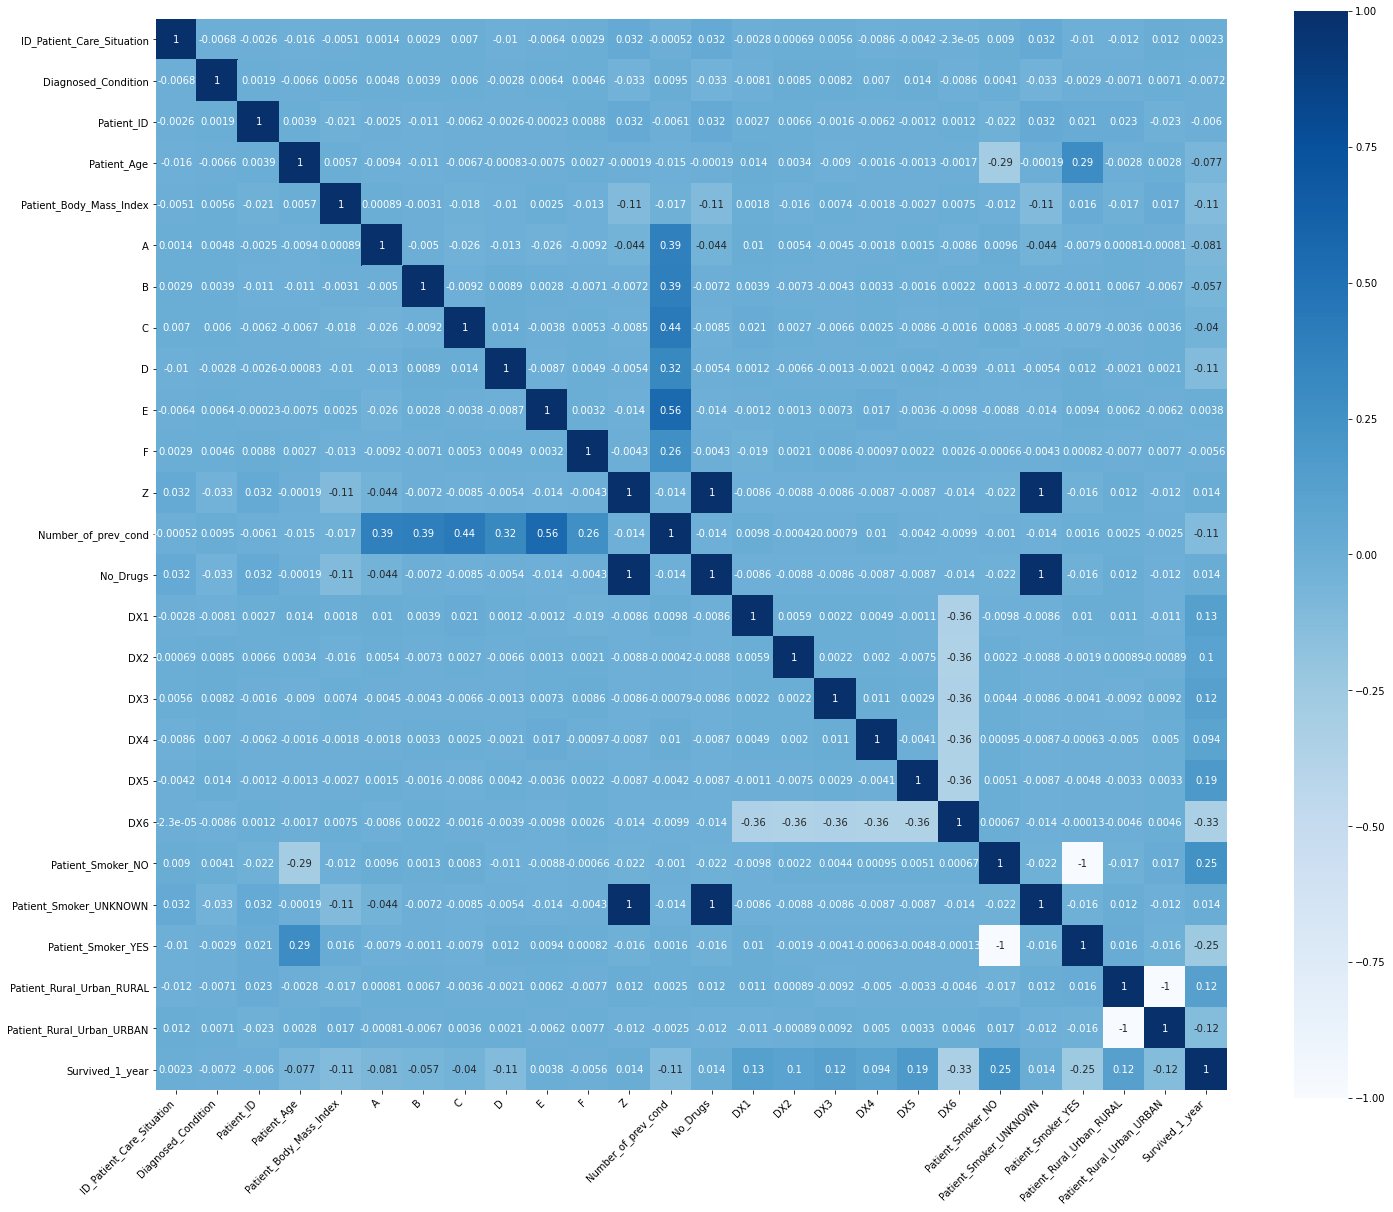

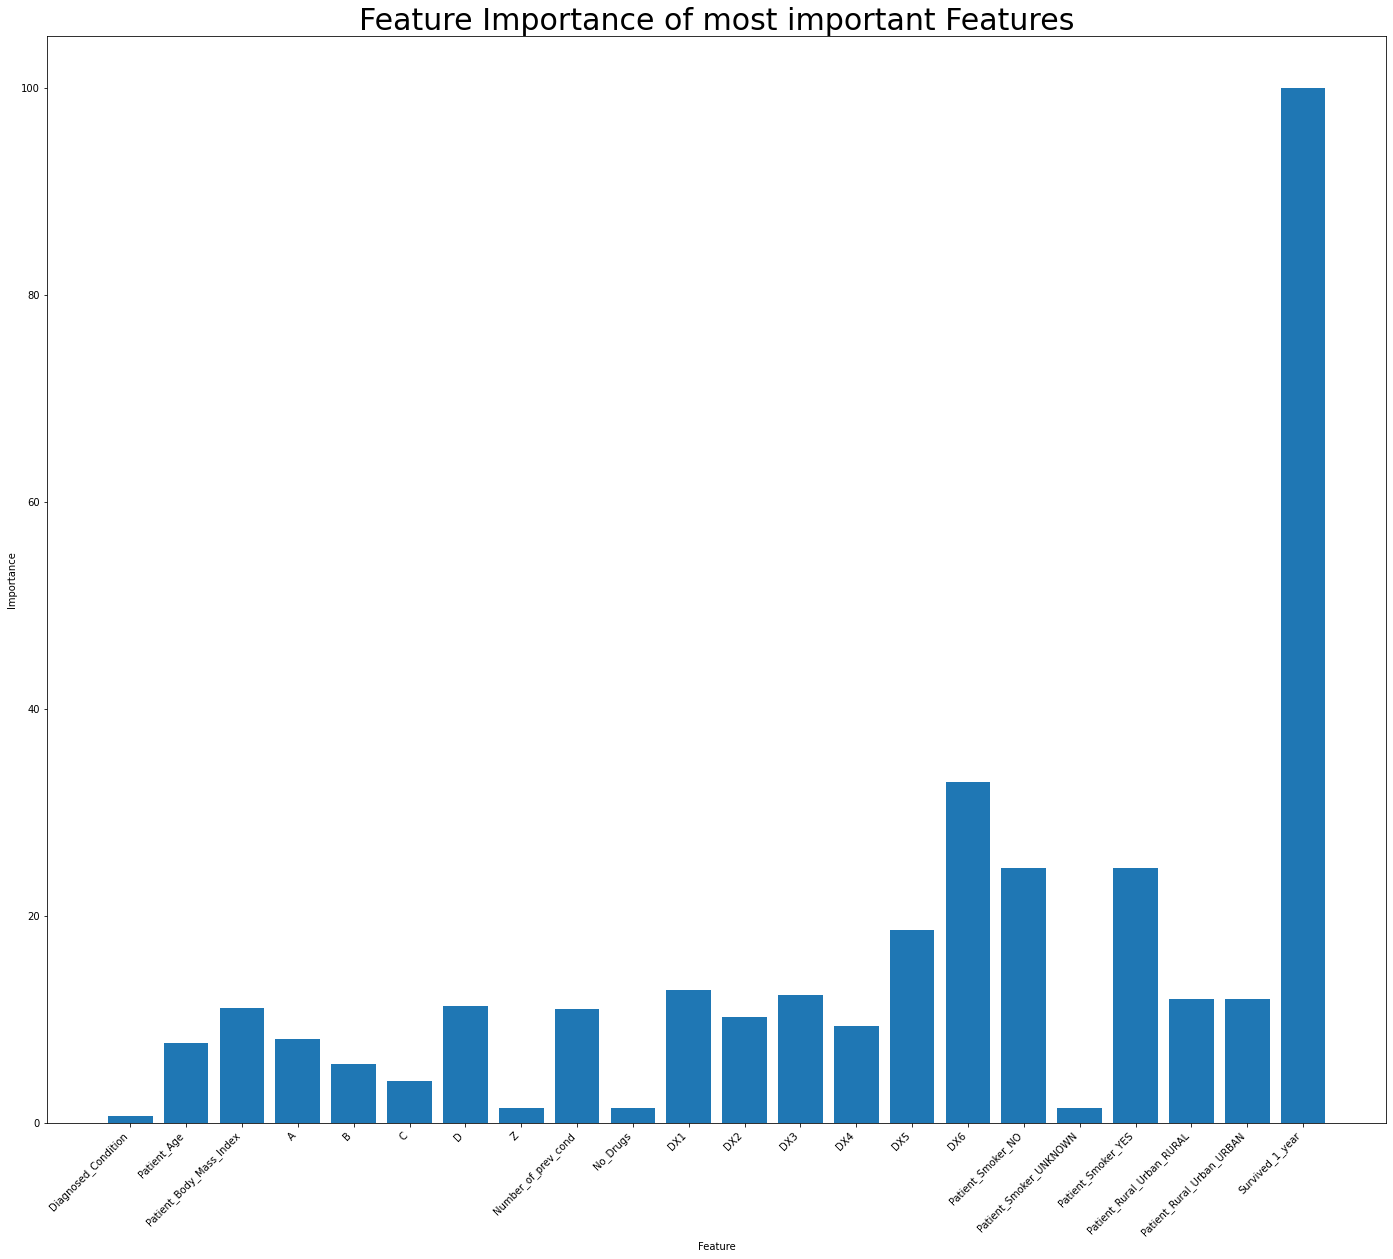

In [14]:
cor_col = container.get_important_features()
# container.get_important_features()

In [15]:
# Show Features with a correlation of greater than +0.7 or less than -0.7.
print(cor_col)

['Diagnosed_Condition', 'Patient_Age', 'Patient_Body_Mass_Index', 'A', 'B', 'C', 'D', 'Z', 'Number_of_prev_cond', 'No_Drugs', 'DX1', 'DX2', 'DX3', 'DX4', 'DX5', 'DX6', 'Patient_Smoker_NO', 'Patient_Smoker_UNKNOWN', 'Patient_Smoker_YES', 'Patient_Rural_Urban_RURAL', 'Patient_Rural_Urban_URBAN', 'Survived_1_year']


In [16]:
cor_col.remove("Survived_1_year")
print(cor_col)

['Diagnosed_Condition', 'Patient_Age', 'Patient_Body_Mass_Index', 'A', 'B', 'C', 'D', 'Z', 'Number_of_prev_cond', 'No_Drugs', 'DX1', 'DX2', 'DX3', 'DX4', 'DX5', 'DX6', 'Patient_Smoker_NO', 'Patient_Smoker_UNKNOWN', 'Patient_Smoker_YES', 'Patient_Rural_Urban_RURAL', 'Patient_Rural_Urban_URBAN']


#### Create a new subset of the data with only the selected features

In [17]:
X_important_train = pd.DataFrame(X_train[cor_col])
X_important_test = pd.DataFrame(X_test[cor_col])

In [18]:
X_important_train.head()

,Diagnosed_Condition,Patient_Age,Patient_Body_Mass_Index,A,B,C,D,Z,Number_of_prev_cond,No_Drugs,DX1,DX2,DX3,DX4,DX5,DX6,Patient_Smoker_NO,Patient_Smoker_UNKNOWN,Patient_Smoker_YES,Patient_Rural_Urban_RURAL,Patient_Rural_Urban_URBAN
3993,9,23,27.053833,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0
13291,18,37,28.495814,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0
14821,37,61,26.188982,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0
13192,0,33,1.089300,0,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,1,0
8369,47,32,27.539629,1,0,0,0,0,2,0,0,0,0,0,0,1,1,0,0,0,1


In [19]:
X_important_test.head()

,Diagnosed_Condition,Patient_Age,Patient_Body_Mass_Index,A,B,C,D,Z,Number_of_prev_cond,No_Drugs,DX1,DX2,DX3,DX4,DX5,DX6,Patient_Smoker_NO,Patient_Smoker_UNKNOWN,Patient_Smoker_YES,Patient_Rural_Urban_RURAL,Patient_Rural_Urban_URBAN
3604,19,43,17.291259,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1
13554,42,32,28.637347,1,1,0,0,0,2,0,0,0,0,0,0,1,0,0,1,1,0
8788,19,33,25.739042,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1
4847,20,28,20.549522,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1
23082,2,38,22.700380,1,0,1,0,0,2,0,0,0,0,0,0,1,1,0,0,1,0


#### Build model with selected features

In [20]:
# Create a new random forest classifier for the most important features and the same hyperparameters
rf_important = RandomForestClassifier()

# Train the new classifier on the new dataset containing the most important features
rf_important.fit(X_important_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [21]:
y_important_pred = rf_important.predict(X_important_test)
rf_imp_fscore = f1_score(y_test, y_important_pred)

#### Evaluation

In [22]:
# Storing Model Performance to container
container.add_model_detail(rf_important, rf_imp_fscore)
print(rf_imp_fscore)

Model Details for:   RandomForestClassifier
0.8591925258591926


### Random Forest and Boruta




Boruta is an all-relevant feature selection method. Unlike other techniques that select small set of features to minimize the error, Boruta tries to capture all the important and interesting features in the dataset with respect to the target variable.

Boruta by default uses random forest but can be used with other algorithms such as LightGBM, XGBoost etc.

In [23]:
# initialize the boruta selector
boruta_forest = RandomForestClassifier()
boruta_selector = BorutaPy(boruta_forest, n_estimators = 'auto', verbose = 2, random_state = 1)

# fit the boruta selector (including converting data to numpy array for Boruta to read it.)
boruta_selector.fit(np.array(X_train), np.array(y_train))

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	4
Tentative: 	0
Rejected: 	19


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	4
Tentative: 	0
Rejected: 	19


BorutaPy(alpha=0.05,
         estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                          class_weight=None, criterion='gini',
                                          max_depth=None, max_features='auto',
                                          max_leaf_nodes=None, max_samples=None,
                                          min_impurity_decrease=0.0,
                                          min_impurity_split=None,
                                          min_samples_leaf=1,
                                          min_samples_split=2,
                                          min_weight_fraction_leaf=0.0,
                                          n_estimators=67, n_jobs=None,
                                          oob_score=False,
                                          random_state=RandomState(MT19937) at 0x7FE8F6B0A050,
                                          verbose=0, warm_start=False),
         max_iter=100, n_estimators=

**Display features in Rank order**

In [24]:
# check selected features
selected_rfe_features = pd.DataFrame({'Feature':list(X_train.columns),
                                      'Ranking':boruta_selector.ranking_})
selected_rfe_features.sort_values(by='Ranking')

,Feature,Ranking
0,Diagnosed_Condition,1
1,Patient_Age,1
2,Patient_Body_Mass_Index,1
17,DX6,1
20,Patient_Smoker_YES,2
18,Patient_Smoker_NO,3
10,Number_of_prev_cond,4
16,DX5,5
6,D,6
3,A,7


In [25]:
# List highest ranking features
boruta_cols = selected_rfe_features[selected_rfe_features['Ranking']<17]['Feature']
print(boruta_cols)

0           Diagnosed_Condition
1                   Patient_Age
2       Patient_Body_Mass_Index
3                             A
4                             B
5                             C
6                             D
7                             E
10          Number_of_prev_cond
12                          DX1
13                          DX2
14                          DX3
15                          DX4
16                          DX5
17                          DX6
18            Patient_Smoker_NO
20           Patient_Smoker_YES
21    Patient_Rural_Urban_RURAL
22    Patient_Rural_Urban_URBAN
Name: Feature, dtype: object


In [26]:
print("No. of significant features (ie. Ranking < 17):", len(boruta_cols), "from the 24 provided.")

No. of significant features (ie. Ranking < 17): 19 from the 24 provided.


In [27]:
# Remove Target feature from list of Ranked features
boruta_cols = boruta_cols.drop(columns = ["Survived_1_year"])

In [28]:
boruta_cols

0           Diagnosed_Condition
1                   Patient_Age
2       Patient_Body_Mass_Index
3                             A
4                             B
5                             C
6                             D
7                             E
10          Number_of_prev_cond
12                          DX1
13                          DX2
14                          DX3
15                          DX4
16                          DX5
17                          DX6
18            Patient_Smoker_NO
20           Patient_Smoker_YES
21    Patient_Rural_Urban_RURAL
22    Patient_Rural_Urban_URBAN
Name: Feature, dtype: object

#### Create a new subset of the data with only the selected features

In [29]:
X_ranked_train = pd.DataFrame(X_train[boruta_cols])
X_ranked_test = pd.DataFrame(X_test[boruta_cols])

#### Build model with selected features

In [30]:
X_ranked_train.head()

,Diagnosed_Condition,Patient_Age,Patient_Body_Mass_Index,A,B,C,D,E,Number_of_prev_cond,DX1,DX2,DX3,DX4,DX5,DX6,Patient_Smoker_NO,Patient_Smoker_YES,Patient_Rural_Urban_RURAL,Patient_Rural_Urban_URBAN
3993,9,23,27.053833,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0
13291,18,37,28.495814,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0
14821,37,61,26.188982,1,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0
13192,0,33,1.089300,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
8369,47,32,27.539629,1,0,0,0,1,2,0,0,0,0,0,1,1,0,0,1


In [31]:
# Create a new random forest classifier for the highest ranked features
rf_ranked = RandomForestClassifier()

# Train the new classifier on the new dataset containing the highest ranked features
rf_ranked.fit(X_ranked_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### Evaluation

In [32]:
y_ranked_pred = rf_ranked.predict(X_ranked_test)
rf_ranked_fscore = f1_score(y_test, y_ranked_pred)

In [33]:
# Storing Model Performance to container
container.add_model_detail(rf_ranked, rf_ranked_fscore)
print(rf_ranked_fscore)

Model Details for:   RandomForestClassifier
0.8601574275665718


Random Forest Classifier with all the features had given F1 score as 83% while after selecting some relavent features the Random Forest Classifier has given f1 score as 84% which is a good improvement in terms of both performance of the model (i.e. the result) and the complexity is also reduced.

### Hyper Parameter Tunning

Hyper Parameter Tunning\
Hyper parameter tunnning helps choose a set of optimal parameters for a model. \

Grid Search was selected as the method to tune hyperparameters as it is exhaustive, 
By default, Grid Search stores the best parameters in 'best_params_'

In [34]:
# Create the parameter grid ??based on the results of random search??
param_grid = {'bootstrap': [True, False],
              'max_depth': [10, 11, 12],
              'max_features': [5, 6, 7],
              'min_samples_leaf': [2, 3, 4],
              'min_samples_split': [12, 14, 16],
              'n_estimators': [50, 100, 125],
              'random_state': [1]}       

In [35]:
rf_imp_grid = RandomForestClassifier()

# Grid search CV
grid_search = GridSearchCV(estimator = rf_imp_grid, 
                           param_grid = param_grid, 
                           cv = 2, 
                           n_jobs = -1,
                           verbose = 2)

In [36]:
grid_search.fit(X_ranked_train, y_train)

Fitting 2 folds for each of 486 candidates, totalling 972 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed: 14.3min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [37]:
print("Grid Search found the following to be the best parameters from the range given:")
grid_search.best_params_

Grid Search found the following to be the best parameters from the range given:


{'bootstrap': False,
 'max_depth': 12,
 'max_features': 6,
 'min_samples_leaf': 2,
 'min_samples_split': 14,
 'n_estimators': 50,
 'random_state': 1}

Predict Target using the best parameters from Grid Search, on just the highly ranked features as per Boruta.

In [38]:
rf_gs = RandomForestClassifier(**grid_search.best_params_)

In [39]:
rf_gs.fit(X_ranked_train, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features=6,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=14,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [40]:
y_ranked_gs_pred = rf_gs.predict(X_ranked_test)

In [41]:
rf_gs_fscore = f1_score(y_test, y_ranked_gs_pred)

In [42]:
# Storing Model Performance to container
container.add_model_detail(rf_gs, rf_gs_fscore)
rf_gs_fscore

Model Details for:   RandomForestClassifier


0.8699866310160428

The accuracy has improved by selecting some good parameters with the help of hyper parameter tunning - GridSearchCV

## Model Evaluation and Selection

In [43]:
best_model, best_score, index = container.select_best_model()
print("\n")
# print("The Model with the Best score and parameters:")
container.print_summary()
model_name = container.extract_name(best_model)




Model Summaries

MODEL NAME			MODEL ACCURACY

 LinearSVC 		 0.3138028169014085

 LogisticRegression 		 0.8042058308108969

 DecisionTreeClassifier 		 0.8221129387824317

 RandomForestClassifier 		 0.8568090787716955

 RandomForestClassifier 		 0.8591925258591926

 RandomForestClassifier 		 0.8601574275665718

 RandomForestClassifier 		 0.8699866310160428
Model Details for:   RandomForestClassifier


It is clearly observable that the f1 score increased.

In [44]:
print('\033[4m' + "The best performing model is:", '\033[0m', model_name)
print("\n")
print('\033[4m' + "Using the following parameters:", '\033[0m')
best_model

The best performing model is:  RandomForestClassifier


Using the following parameters: 


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features=6,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=14,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [45]:
print(model_name, "with optimal parameters gives an F1 accuracy score of:")
best_score

RandomForestClassifier with optimal parameters gives an F1 accuracy score of:


0.8699866310160428

In [46]:
if index == 0:
    XTrain = X_train
    XTest = X_test  
elif index >0 and index <4:
    XTrain = X_important_train
    XTest = X_important_test  
else:
    XTrain = X_ranked_train
    XTest = X_ranked_test  

best_model.fit(XTrain, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features=6,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=14,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [47]:
# Summarize results
container.select_best_model()
container.print_summary()


Model Summaries

MODEL NAME			MODEL ACCURACY

 LinearSVC 		 0.3138028169014085

 LogisticRegression 		 0.8042058308108969

 DecisionTreeClassifier 		 0.8221129387824317

 RandomForestClassifier 		 0.8568090787716955

 RandomForestClassifier 		 0.8591925258591926

 RandomForestClassifier 		 0.8601574275665718

 RandomForestClassifier 		 0.8699866310160428


### Save Best Model

In [48]:
container.save_results()

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features=6,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=14,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


### **Save Data**

In [49]:
New_X = (New_X[boruta_cols])
New_X.head()

,Diagnosed_Condition,Patient_Age,Patient_Body_Mass_Index,A,B,C,D,E,Number_of_prev_cond,DX1,DX2,DX3,DX4,DX5,DX6,Patient_Smoker_NO,Patient_Smoker_YES,Patient_Rural_Urban_RURAL,Patient_Rural_Urban_URBAN
0,35,65,20.710365,1,0,0,0,1,2,0,0,0,0,1,0,1,0,1,0
1,30,2,24.250219,1,0,0,0,1,2,1,0,0,0,0,0,1,0,0,1
2,46,1,27.139276,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1
3,44,29,29.191759,0,0,1,0,1,2,1,0,0,0,0,0,1,0,1,0
4,30,51,20.844146,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,1


In [50]:
# pickle Training data
X_ranked_train.to_pickle('/content/drive/My Drive/Heart_Patient/Data/train_data_4_predict.pkl')

# pickle Testing data
New_X.to_pickle('/content/drive/My Drive/Heart_Patient/Data/new_test_data_4_predict.pkl')

# **Save Predictions**

In [51]:
rf_gs

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features=6,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=14,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [52]:
X_ranked_test.head()

,Diagnosed_Condition,Patient_Age,Patient_Body_Mass_Index,A,B,C,D,E,Number_of_prev_cond,DX1,DX2,DX3,DX4,DX5,DX6,Patient_Smoker_NO,Patient_Smoker_YES,Patient_Rural_Urban_RURAL,Patient_Rural_Urban_URBAN
3604,19,43,17.291259,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1
13554,42,32,28.637347,1,1,0,0,0,2,0,0,0,0,0,1,0,1,1,0
8788,19,33,25.739042,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1
4847,20,28,20.549522,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1
23082,2,38,22.700380,1,0,1,0,0,2,0,0,0,0,0,1,1,0,1,0


In [53]:
predictions = (rf_gs.predict(X_ranked_test))

The predicted output (Target Feature) is now stored in the variable 'prediction'. 

In [54]:
pd.DataFrame(rf_gs.predict(X_ranked_test)).to_csv('/content/drive/My Drive/Heart_Patient/Data/DataPredictions.csv')